# Udacity Deep Reinforcement Learning ND
## Project 2: Continuous Control

### Author: Nicolas Benielli Borrajo

------------------


### Summary: 
In this notebook I implemented a **Deep Deterministic Policy Gradient** ([DDPG](https://arxiv.org/abs/1509.02971)) to solve Unity's *Reacher* environment for the case of a single agent. I explored hyperparameters that made the vanilla case (which is DDPG with Action Space Noise, a stochastic process added to the output of the Actor network), and then I introduceced two variations:


 - **Parameter Space Noise** ([PSN](https://arxiv.org/abs/1706.01905)), where the noise is added directly to the weights of the Actor network, and
 
 - **Prioritized Experience Replay** ([PER](https://arxiv.org/abs/1511.05952)], where the memory buffer is stored and sampled by following a distribution that assigns higher priority to transitions that result into higher TD errors.

### Goal and Motivation:
The main goal for this project is to assess the improvements on the learning algorithm by switching the exploration strategy from perturbating the actions to perturbating the actor weights in an adaptative way. My main motivation is that I have not seen PSN included in State-of-the-Art models, yet I find it a simple but versatile approach for the exploration problem. Also, I wanted to include a more advanced memory model than the uniformly-sampled used in the DDPG paper, so I explored the incorporation of PER into my learner.

### Results:
I conducted an ablation study in order to identify the individual contributions of both PSN and PER to the vanilla DDPG case. The number of episodes that took each agent to solve the environment are:

 
 1. **Vanilla DDPG**: not solving - more than 1000 episodes

 2. **DDPG with PSN**: 257 episodes
 
 3. **DDPG with PER**: 452 episodes
 
 4. **DDPG with PSN and PER**: 276 episodes

## 1. Environment and Agent

In [ ]:
!pip -q install ./python
!pip install unityagents

In [7]:
import gym
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from unityagents import UnityEnvironment

Make environment using downloaded file:

In [8]:
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')
env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher')


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Env info:

In [9]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)

# size of each action
action_size = brain.vector_action_space_size

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]

print('State size:', state_size, 'Action_size:', action_size)

State size: 33 Action_size: 4


### Actor and Critic networks

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=128):
        """Initialize parameters and build model."""
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.bn1(self.fc1(state)))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=128, fc2_units=128):
        """Initialize parameters and build model."""
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.bn1 = nn.BatchNorm1d(fcs1_units)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.bn1(self.fcs1(state)))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### Noise models

In [12]:
import numpy as np
import random
import copy
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.2, sigma=0.1):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self, epsilon = 1.0):
        """Update internal state and return it as a noise sample."""
        x = self.state
        #dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        dx = epsilon*(self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))]))
        self.state = x + dx
        return self.state

class PSNoise:
    """Parameter Space Noise"""

    def __init__(self, state_size, action_size, seed, sigma=0.1, scalar = 1.01, treshold = 0.3):
        """Initialize parameters and noise process."""
        self.state_size = state_size
        self.action_size = action_size
        self.sigma = sigma
        self.treshold = treshold
        self.scalar = scalar
        self.adapt_step = 0
        self.policy_pert = Actor(self.state_size, self.action_size, seed).to(device)
           
    def reset(self, policy):
        """Perturbate actor's fc layer at the beginning of the episode"""
        with torch.no_grad():
            for param in policy.parameters():
                noise = torch.randn(param.size()) * self.sigma
                param.add_(noise.float().to(device))

        
    def get_distance(self, action_size, policy, states_batch, sigma):
        """Computes distance between perturbed and non-perturbed policies""" 
        actions_no_pert = policy(states_batch).cpu().data.numpy()
        
        #copy weights
        with torch.no_grad():
            for param_nonpert, param_pert in zip(policy.parameters(), self.policy_pert.parameters()):
                param_pert.data.copy_(param_nonpert.data)
      
      
        #perturbed policy
        with torch.no_grad():
            for param_pert in self.policy_pert.parameters():
                noise = torch.randn(param_pert.size()) * self.sigma
                param_pert.add_(noise.float().to(device))
      
        actions_pert = self.policy_pert(states_batch).cpu().data.numpy()
      
        distance = np.sqrt(np.mean((actions_no_pert - actions_pert)**2))
      
        return distance 
      
      
    def adapt(self, distance):
        """Updates sigma"""
        if distance <= self.treshold:
            self.sigma = self.scalar * self.sigma
        else:
            self.sigma = self.sigma / self.scalar
        self.treshold = self.sigma
    
    
    def update_noise(self, policy, states_batch):
        """Adaptative scaling"""
                          
        self.adapt_step = (self.adapt_step + 1) % ADAPT_EVERY
        #change sigma (adapt)
        if self.adapt_step == 0:   
          #compute distance
          distance = self.get_distance(self.action_size, policy, states_batch, sigma = self.sigma)
          
          self.distance = distance
          
          #update sigma
          self.adapt(distance)
          
          #perturbed policy with updated sigma
          with torch.no_grad():
            for param in agent.actor_local.parameters():
                noise = torch.randn(param.size()) * self.sigma
                param.add_(noise.float().to(device))

### Memory models

In [13]:
import numpy as np
from collections import namedtuple, deque
import random
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object."""

        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

class ReplayBufferPE:
    """Fixed-size buffer to store experience tuples and sample with proportional prioritization."""

    def __init__(self, action_size, buffer_size, batch_size, seed, alpha):
        """Initialize a ReplayBuffer object."""

        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)      # internal memory for S,A,R,S',done (deque)
        self.priorities = deque(maxlen=buffer_size)  # internal memory priorities (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.alpha = max(0., alpha)
        self.max_priority = 1.0**self.alpha
        self.cum_priorities = 0.
        self.epsilon = 1e-6
        self.experiences_idx = []
   
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        # Add experience
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        # Update priorities and cum_priorities
        self.priorities.append(self.max_priority)
        # Accumulate the priorities
        self.cum_priorities = np.sum(self.priorities)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        probs = np.array(self.priorities) / self.cum_priorities
        len_memory = len(self.memory)
        self.experiences_idx = np.random.choice(len_memory, min(len_memory, self.batch_size), p = probs)
        experiences = [self.memory[i] for i in self.experiences_idx]

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def get_weights(self, beta):
        """Returns Importance Sampling weights wi"""
        len_memory = len(self.memory)
        max_weight = (len_memory * min(self.priorities) / self.cum_priorities) ** beta
        weights = np.array([((len_memory * (self.priorities[i] / self.cum_priorities))**(-beta))/max_weight for i in self.experiences_idx])
        return torch.from_numpy(weights).float().to(device)
    
    def update_priorities(self, td_errors):
        """ Update priorities of sampled transitions """

        for i, td_error in zip(self.experiences_idx, td_errors):
            td_error = float(td_error)
            self.cum_priorities -= self.priorities[i]
            self.priorities[i] = ((abs(td_error) + self.epsilon) ** self.alpha)
            self.cum_priorities += self.priorities[i]
        #update max priority value
        self.max_priority = max(self.priorities)
    
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### DDPG Agent

In [14]:
import random
import copy
from collections import namedtuple, deque
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed, add_noise = True, PER = False, PSN = True):
        """Initialize an Agent object."""
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.add_noise = add_noise

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.PSN = PSN
        if self.add_noise:
            if self.PSN:
                self.noise = PSNoise(state_size, action_size, random_seed)
            else:
                self.noise = OUNoise(action_size, random_seed)
          
        # Replay memory
        self.PER = PER
        if self.PER:
            self.memory = ReplayBufferPE(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed, alpha = ALPHA)
            self.beta = BETA_INITIAL
        else:
            self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        
        # Initialize learning steps 
        self.learn_step = 0  
    
    def reset(self):
        if self.add_noise:
            if self.PSN:
                self.noise.reset(self.actor_local)
            else:
                self.noise.reset()    
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)
        
        if len(self.memory) > BATCH_SIZE:
            # Learn, if enough samples are available in memory for number of timesteps
            for _ in range(STEPS_UPDATE):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)
        
    def act(self, state, epsilon = 1, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        
        #If add_noise = True:
        if self.add_noise:
          #Add AS or PS noise:
          if self.PSN:
            # Parameter Space Noise
            if len(self.memory) > BATCH_SIZE:
              # PS noise needs to sample from memory to perturbate actor weights
              self.noise.update_noise(self.actor_local, states_batch = self.memory.sample()[0])
            with torch.no_grad():
                action = self.actor_local(state).cpu().data.numpy()
            self.actor_local.train()
          # Action Space Noise
          else:
            with torch.no_grad():
                action = self.actor_local(state).cpu().data.numpy()
            self.actor_local.train()
            action += self.noise.sample(epsilon)
        #If add_noise = False, no noise is added
        else:
            with torch.no_grad():
                action = self.actor_local(state).cpu().data.numpy()

        #For all cases, return clipped action      
        return np.clip(action, -1, 1)

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples."""    
        
        states, actions, rewards, next_states, dones = experiences
               
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute Q expected
        Q_expected = self.critic_local(states, actions)
        
        # Compute critic loss        
        if self.PER:
          # Update Beta
          self.beta += BETA_INCREMENT
          # Get RB weights
          weights = self.memory.get_weights(self.beta)
          # Clip abs(TD_errors)
          TD_errors = torch.clamp(torch.abs(Q_targets - Q_expected), min=0., max=1.)
          # Update replay buffer with proportional probs
          self.memory.update_priorities(TD_errors)
          #compute weighted mse loss     
          critic_loss = torch.mean(weights * (Q_expected - Q_targets) ** 2)
        else:
          #compute mse loss  
          critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize critic loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        # Clip critic gradient
        torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean() #NEGATIVE: gradiet ascent
        
        # Minimize actor loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Soft updates for target networks
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


### Utils

In [35]:
import pandas as pd

def train(env, agent, n_episodes=500, max_t=1000):
    scores_deque = deque(maxlen=100)
    scores_list = []
    max_score = -np.Inf
    epsilon = 1.0
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        agent.reset()
        for t in range(max_t):
            actions = agent.act(states, epsilon)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished

            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            scores += rewards
            
            if np.any(dones):
                break
                
        score = np.mean(scores)
        scores_deque.append(score)
        scores_list.append(score)
        epsilon *= 0.999
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))   
        if np.mean(scores_deque) >= 31:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
        
    return scores_list

def save_weights(agent, test_name):
    actor_name = 'weights_actor_'+str(test_name)+'.pth'
    critic_name = 'weights_critic_'+str(test_name)+'.pth'
    torch.save(agent.actor_local.state_dict(), actor_name)
    torch.save(agent.critic_local.state_dict(), critic_name)

def save_scores(scores, test_name):
    scores = pd.DataFrame({'Scores':scores})
    scores_name = str(test_name)+'-scores.csv'
    scores.to_csv(scores_name, sep=',')
    print('Learning curve saved in', scores_name)

def plot_smooth(scores, test_name, smoothing_window = 10):
    scores = pd.DataFrame({'Scores':scores})
    fig = plt.figure(figsize=(10,5))
    plt.grid(True)
    plt.style.use('seaborn-bright')
    rewards_smoothed = scores.rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    plot_name = str(test_name)+'-plot.png'
    plt.savefig(plot_name)

def plot_rewards(test_names, smoothing_window = 100): 
    #create df from test names
    plot_df = pd.DataFrame()
    for model in test_names:
        name = model +'-scores.csv'
        scores = pd.read_csv(name, index_col=None)
        scores = pd.Series(scores['Scores'])
        plot_df = pd.concat([plot_df, scores], axis=1)
    plot_df.columns = test_names  
    #plot    
    legends = test_names 
    fig = plt.figure(figsize=(10,5))
    plt.grid(False)
    plt.style.use('seaborn-bright')
    rewards_smoothed = plot_df.rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.axhline(y=30, color='g', linestyle='--')
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.legend(legends)
    plt.savefig('results.png')
    
def set_hyperparameters():
    BUFFER_SIZE = int(1e6)  # replay buffer size
    BATCH_SIZE = 128       # minibatch size
    GAMMA = 0.99            # discount factor
    TAU = 1e-3              # for soft update of target parameters
    LR_ACTOR = 2e-4         # learning rate of the actor 
    LR_CRITIC = 2e-4        # learning rate of the critic
    WEIGHT_DECAY = 0        # L2 weight decay
    BETA_INITIAL = 0.0      # Prioritized Experience Replay initial weight decay
    BETA_INCREMENT = 1e-6   # Step-wise Beta increment
    ALPHA = 0.3             # Prioritized Experience Replay weight sampling importance
    ADAPT_EVERY = 100       # Frequency for adapting Parameter Space Noise weights
    STEPS_UPDATE = 1        # Frequency for updating critic network

## 2. Results

### 2.1 First case: Vanilla DDPG

In this case, I'll train an agent that implements a DDPG method with a vanilla Replay Buffer memory (```PER=False```) and action space noise following an OU process (```add_noise = True; PSN=False```)

In [22]:
set_hyperparameters()

#Instantiate agent
agent = Agent(state_size=state_size, action_size=action_size, random_seed=1, add_noise = True, PER=False, PSN = False)

#### Train

In [14]:
scores = train(env, agent)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:131: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Episode 100	Average Score: 3.01
Episode 200	Average Score: 5.85
Episode 300	Average Score: 6.78
Episode 400	Average Score: 8.12
Episode 500	Average Score: 9.05
Episode 600	Average Score: 11.34
Episode 700	Average Score: 13.90
Episode 800	Average Score: 15.71
Episode 900	Average Score: 21.28
Episode 1000	Average Score: 26.23


#### Save results:

Learning curve saved in ddpg_vanilla-scores.csv


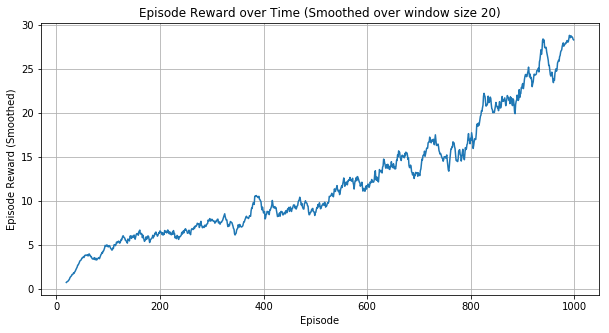

In [15]:
test_name = 'ddpg_vanilla'

#save weights
save_weights(agent, test_name)

#save scores
save_scores(scores, test_name)

#plot and save smoothed learning curve
plot_smooth(scores, test_name, smoothing_window = 20)

### 2.2 Second case: DDPG with Parameter Space Noise

In this case, I'll train an agent that implements a DDPG method with a vanilla Replay Buffer memory (```PER=False```) and parameter space noise (```add_noise = True; PSN=True```):

In [12]:
set_hyperparameters()

#Instantiate agent
agent = Agent(state_size=state_size, action_size=action_size, random_seed=1, add_noise = True, PER=False, PSN = True)

#### Train

In [13]:
scores = train(env, agent)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:151: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Episode 100	Average Score: 5.39
Episode 200	Average Score: 23.93
Episode 257	Average Score: 31.02
Environment solved in 257 episodes!	Average Score: 31.02


#### Save results:

Learning curve saved in ddpg_psn-scores.csv


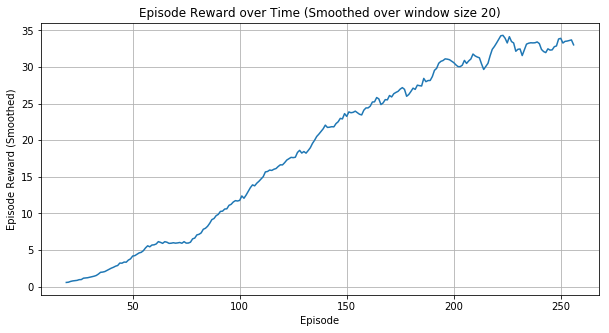

In [16]:
test_name = 'ddpg_psn'

#save weights
save_weights(agent, test_name)

#save scores
save_scores(scores, test_name)

#plot and save smoothed learning curve
plot_smooth(scores, test_name, smoothing_window = 20)

### 2.3 Third case: DDPG with Prioritized Experience Replay

In this case, I'll train an agent that implements a DDPG method with a Prioritized Experience Replay buffer memory (```PER=True```) and stochastic action space noise (```add_noise = True; PSN=False```):

In [19]:
set_hyperparameters()

#Instantiate agent
agent = Agent(state_size=state_size, action_size=action_size, random_seed=1, add_noise = True, PER=True, PSN = False)

#### Train:

In [20]:
scores = train(env, agent)

C:\Users\nbbor\Anaconda3\envs\mytf\lib\site-packages\ipykernel_launcher.py:131: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Episode 100	Average Score: 3.77
Episode 200	Average Score: 9.60
Episode 300	Average Score: 16.01
Episode 400	Average Score: 26.62
Episode 452	Average Score: 31.03
Environment solved in 452 episodes!	Average Score: 31.03


#### Save results:

Learning curve saved in ddpg_per-scores.csv


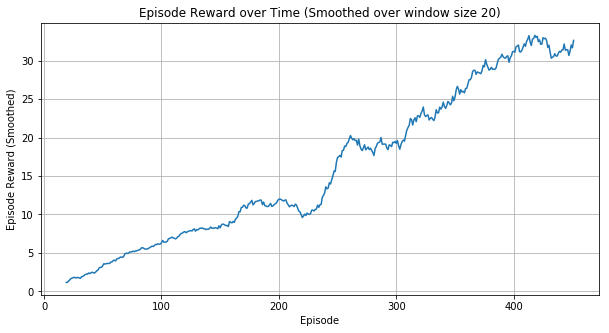

In [21]:
test_name = 'ddpg_per'

#save weights
save_weights(agent, test_name)

#save scores
save_scores(scores, test_name)

#plot and save smoothed learning curve
plot_smooth(scores, test_name, smoothing_window = 20)

### 2.4 Fourth case: DDPG with Prioritized Experience Replay and Parameter Space Noise

Finally, I'll train an agent that implements a DDPG method with a Prioritized Experience Replay buffer memory (```PER=True```) and Parameter Space Noise (```add_noise = True; PSN=True```) all combined:

In [23]:
set_hyperparameters()

#Instantiate agent
agent = Agent(state_size=state_size, action_size=action_size, random_seed=1, add_noise = True, PER = True, PSN = True)

#### Train:

In [24]:
scores = train(env, agent)

C:\Users\nbbor\Anaconda3\envs\mytf\lib\site-packages\ipykernel_launcher.py:131: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Episode 100	Average Score: 3.71
Episode 200	Average Score: 15.31
Episode 276	Average Score: 31.05
Environment solved in 276 episodes!	Average Score: 31.05


#### Save Results:

Learning curve saved in ddpg_per_psn-scores.csv


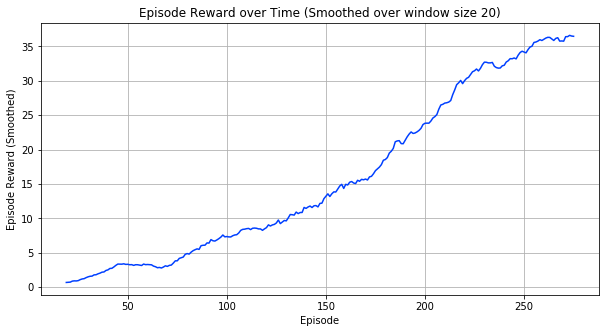

In [25]:
test_name = 'ddpg_per_psn'

#save weights
save_weights(agent, test_name)

#save scores
save_scores(scores, test_name)

#plot and save smoothed learning curve
plot_smooth(scores, test_name, smoothing_window = 20)

In [26]:
env.close()

## 3. Analysis of results

Results shown that while the vanilla DDPG agent needs more than 1000 episodes to solve with the chosen set of hyperparameters (it worth to notice no hyperparameter tuning was performed), when switching the noise process to an adaptative noise in the state parameters (actor weights) the learning curve improves drastically. On the other hand, while sampling experiences in a prioritized way also improves the learning process, it also drastically increases the training wall time, mostly because the implementation of PER I made is the naive one, where the sampling process turns into a binary search of complexity O(n). The following curve shows all learning curves together for comparison: 

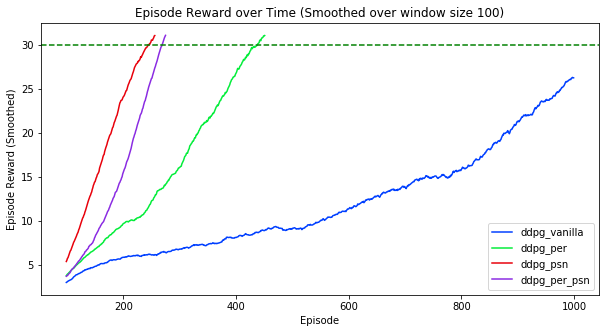

In [36]:
test_names = ['ddpg_vanilla', 'ddpg_per', 'ddpg_psn', 'ddpg_per_psn']
plot_rewards(test_names)

We can see that all agents but vanilla DDPG are able to solve the environment in less than 1000 episodes, where the solving criteria is having an average reward greater than 30 in 100 consecutive episodes.

## 4. Further improvements

As further work I'd start by conducting a careful hyperparameter tuning, making the vanilla DDPG agent being able to solve the environment in less than 1000 episodes. Also, it became clear that a better implementation of PER is needed, perhaps implementing a more efficient data structure for the sampling step in order to reduce the complexity (hopefully O(log(n)) ). Finally, as this project only considers one single agent learning in isolation, it worth to explore distributed learning algorithms such as A3C, D4PG, etc.